In [1]:
# TEST SET (reloading independent code fragment for now sampled excel)

# Import CNN Zero-Shot & other necessary stuff
from transformers import pipeline  # It takes time here

# For data input and data cleaning
import pandas as pd
from nltk.tokenize import regexp_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from numpy import NaN
import time

# Available directories (input yours for personal use)
cep_data_dir = "/home/aan0709@tmme/pcu-research-mapping/data/"

working_dir = "TEST/"  # CHANGE WORKING DIRECTORY INSIDE IEEE XPLORE FOLDER


# For data importing
def openExcel(excel_name, sheet_name, directory):
    df = pd.read_excel(directory + excel_name + ".xlsx", sheet_name=sheet_name)
    return df


def cleanIndexes(df):
    temp_ls = df.columns
    for i in df.columns:
        if i == "abstract":
            break
        df.drop(columns=[i], inplace=True)
    return df


# Select INPUT EXCEL
file_name = (
    "TESTSET_GaN_answered"  # -> I have edited the Affiliations and the Keywords part
)

df = openExcel(file_name, "Sheet1", cep_data_dir + working_dir)

df = cleanIndexes(df)
df.reset_index(drop=True, inplace=True)

In [3]:
start = time.time()
classifierGPU0 = pipeline(
    "zero-shot-classification", model="facebook/bart-large-mnli", device=3
)
end = time.time()
print("seconds elapsed: ", end - start)

seconds elapsed:  11.147302627563477


In [9]:
count_diff = 0
count_all = len(df)

# Print differences
for i in range(len(df)):
    if df.loc[i, "Manual Judgement"] != df.loc[i, "ZeroShot Judgement"]:
        count_diff += 1

print(
    "From %d papers, the %d are CORRECT and the %d are WRONG ( %.2f percent correct )\n"
    % (
        count_all,
        count_all - count_diff,
        count_diff,
        (100 * (count_all - count_diff) / count_all),
    )
)

From 50 papers, the 33 are CORRECT and the 17 are WRONG ( 66.00 percent correct )



In [6]:
count_diff = 0
count_all = len(df)

# Print differences
for i in range(len(df)):
    if df.loc[i, "Manual Judgement"] == 0:
        count_diff += 1

print(
    "From %d papers, the %d are CORRECT and the %d are WRONG ( %.2f percent correct )\n"
    % (
        count_all,
        count_all - count_diff,
        count_diff,
        (100 * (count_all - count_diff) / count_all),
    )
)

From 50 papers, the 17 are CORRECT and the 33 are WRONG ( 34.00 percent correct )



In [24]:
# TEST 0 - best @ >?? w/ IEEE Keywords

positive_outcome = "gallium nitride"
# negative_outcome = "not traction inverter"

candidate_labels = [positive_outcome]  # , negative_outcome]
hypothesis_template = "The research is about {}?"  # Categorization question

In [5]:
# TEST 1 - best @ >0.1 w/ IEEE Keywords - 96% w/ and w/o abstract

positive_outcome = "gallium nitride HEMT"
negative_outcome = (
    "generative adversarial network light emitting diode photodetector optics laser"
)

candidate_labels = [positive_outcome, negative_outcome]

hypothesis_template = "The research is about {}?"  # Categorization question

In [8]:
# TEST 2 - worst solution

# It's not working well. Gallium nitride is repeated as Gallium Gallium nitride nitride which confuses the model.
# Also, double repeating doesn't help because the category's IEEE keyword is too strong to be repeated twice.

positive_outcome = "gallium nitride GaN HEMT FET switches wide band gap semiconductors"
negative_outcome = "generative adversarial network light emitting diode diode photodetector optics laser"

candidate_labels = ["gallium nitride", "GaN"]

hypothesis_template = "The research is about {}?"  # Categorization question

In [6]:
from stop_words import get_stop_words
from nltk.corpus import stopwords

percentages = []
for perc_loop in range(0, 100, 5):

    en_stopwords = []
    en_stopwords = list(get_stop_words("en"))  # About 900 stopwords
    nltk_words = list(stopwords.words("english"))  # About 150 stopwords
    en_stopwords.extend(nltk_words)

    lemma = WordNetLemmatizer()

    Author_Keywords = "index_terms.author_terms.terms"
    IEEE_Keywords = "index_terms.ieee_terms.terms"

    count_all = len(df)
    count_diff = 0

    start = time.time()

    input_text = []  # This is the list that will be my dataset for the pipeline
    input_index = []
    final_judgement_dict = {}
    for i in range(len(df)):
        data = ""
        # Where to search
        if isinstance(df.loc[i, "abstract"], str):
            data += df.loc[i, "abstract"]
        if isinstance(df.loc[i, "title"], str):
            data += " " + df.loc[i, "title"]
        exception_to_str = df.loc[i, IEEE_Keywords]
        if isinstance(exception_to_str, str):
            exception_to_str = " ".join(df.loc[i, IEEE_Keywords].split(";"))
            data += " " + exception_to_str
        exception_to_str = df.loc[i, Author_Keywords]
        if isinstance(exception_to_str, str):
            exception_to_str = " ".join(df.loc[i, Author_Keywords].split(";"))
            data += " " + exception_to_str
            # printing_data = data

        # Data Cleaning with NLTK, NumPy
        tokens = regexp_tokenize(data, pattern=r"\s|[\/.,;'()]", gaps=True)
        words = []
        for k in tokens:
            if k not in en_stopwords and len(k) > 2:
                k = lemma.lemmatize(k)
            words.append(k)
        data = " ".join(words)

        kill_words = [
            "iode",
            "etwork",
            "photo",
            "optic",
        ]
        flag = False
        for kill_word in kill_words:
            if kill_word in data:
                # print("entered")
                df.loc[i, "ZeroShot Judgement"] = 0
                flag = True
                break
        if flag:
            continue

        # Rienforcing the data with keyword
        tokens = regexp_tokenize(data, pattern=r"\s|[\&<>\.,;'()]", gaps=True)
        for j in tokens:  # For every word in the data:
            lc_j = j.lower()
            if (
                len(j) > 3
            ):  # this excludes ie. the BJTs keyword, so be careful (but also filters out words like "and" etc)
                # for k in regexp_tokenize("".join(candidate_labels), pattern=r"\s|[\&<>\.,;'()]", gaps=True):
                for k in candidate_labels:
                    lc_k = k.lower()
                    if lc_j in lc_k:
                        data += " " + j  # + " " + j)

        # print(data)

        # Some papers are excluded from the IEEE keywords.
        input_text.append(data)
        input_index.append(i)

    # ~JUDGE~
    print("#papers= %d" % (len(input_text)))

    start_judge = time.time()
    index = 0
    zero_shot_judgement = []
    for final_judgement_dict in classifierGPU0(
        input_text,
        candidate_labels,
        hypothesis_template=hypothesis_template,
        batch_size=16,
        multi_label=True,
    ):
        if (
            final_judgement_dict["labels"][0] in positive_outcome
            and final_judgement_dict["scores"][0] > perc_loop / 100.0
        ):
            zero_shot_judge = 1
        else:
            zero_shot_judge = 0
        zero_shot_judgement.append(zero_shot_judge)
    for c in range(len(input_index)):
        df.loc[input_index[c], "ZeroShot Judgement"] = zero_shot_judgement[c]
    print("#Papers = %d, Time elapsed: %.2f" % (i + 1, (time.time() - start)))

    end = time.time()

    # Print differences
    for i in range(len(df)):
        if df.loc[i, "ZeroShot Judgement"] != df.loc[i, "Manual Judgement"]:
            count_diff += 1

    percentages.append((count_all - count_diff) / count_all)
    print(perc_loop / 100)
    m, s = divmod(end - start, 60)
    print("Time: %d min %0.3f sec" % (m, s))
    print(
        "From %d papers, the %d are CORRECT and the %d are WRONG ( %.2f percent correct )\n"
        % (
            count_all,
            count_all - count_diff,
            count_diff,
            (100 * (count_all - count_diff) / count_all),
        )
    )

#papers= 25
#Papers = 50, Time elapsed: 2.89
0.0
Time: 0 min 2.894 sec
From 50 papers, the 43 are CORRECT and the 7 are WRONG ( 86.00 percent correct )

#papers= 25
#Papers = 50, Time elapsed: 1.37
0.05
Time: 0 min 1.368 sec
From 50 papers, the 46 are CORRECT and the 4 are WRONG ( 92.00 percent correct )

#papers= 25
#Papers = 50, Time elapsed: 1.39
0.1
Time: 0 min 1.393 sec
From 50 papers, the 47 are CORRECT and the 3 are WRONG ( 94.00 percent correct )

#papers= 25
#Papers = 50, Time elapsed: 1.38
0.15
Time: 0 min 1.382 sec
From 50 papers, the 48 are CORRECT and the 2 are WRONG ( 96.00 percent correct )

#papers= 25
#Papers = 50, Time elapsed: 1.36
0.2
Time: 0 min 1.360 sec
From 50 papers, the 48 are CORRECT and the 2 are WRONG ( 96.00 percent correct )

#papers= 25
#Papers = 50, Time elapsed: 1.39
0.25
Time: 0 min 1.387 sec
From 50 papers, the 48 are CORRECT and the 2 are WRONG ( 96.00 percent correct )

#papers= 25
#Papers = 50, Time elapsed: 1.41
0.3
Time: 0 min 1.415 sec
From 50 

/home/aan0709@tmme/.local/lib/python3.7/site-packages/transformers/pipelines/base.py:978: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  UserWarning,


#Papers = 50, Time elapsed: 1.37
0.5
Time: 0 min 1.375 sec
From 50 papers, the 48 are CORRECT and the 2 are WRONG ( 96.00 percent correct )

#papers= 25
#Papers = 50, Time elapsed: 1.40
0.55
Time: 0 min 1.397 sec
From 50 papers, the 47 are CORRECT and the 3 are WRONG ( 94.00 percent correct )

#papers= 25
#Papers = 50, Time elapsed: 1.39
0.6
Time: 0 min 1.388 sec
From 50 papers, the 47 are CORRECT and the 3 are WRONG ( 94.00 percent correct )

#papers= 25
#Papers = 50, Time elapsed: 1.40
0.65
Time: 0 min 1.401 sec
From 50 papers, the 47 are CORRECT and the 3 are WRONG ( 94.00 percent correct )

#papers= 25
#Papers = 50, Time elapsed: 1.37
0.7
Time: 0 min 1.368 sec
From 50 papers, the 46 are CORRECT and the 4 are WRONG ( 92.00 percent correct )

#papers= 25
#Papers = 50, Time elapsed: 1.37
0.75
Time: 0 min 1.371 sec
From 50 papers, the 45 are CORRECT and the 5 are WRONG ( 90.00 percent correct )

#papers= 25
#Papers = 50, Time elapsed: 1.38
0.8
Time: 0 min 1.379 sec
From 50 papers, the 

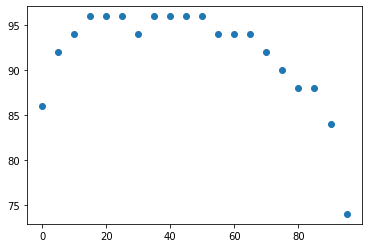

In [7]:
import matplotlib.pyplot as plt

x = list(range(0, 100, 5))
for i in range(len(x)):
    percentages[i] = percentages[i] * 100

plt.scatter(x, percentages)
plt.show()